In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tqdm.auto import tqdm

# <center> Homework: Errors in Markov Chains and PageRank</center>

The goal of this homework is twofold: in the first part you will evaluate errors in Markov chain Monte Carlo. In the second part, you will study the PageRank algorithm.

## <center> Part I: Markov Chain Monte Carlo</center>

### **A particle on the top of a Mexican hat**

We consider a particle on the xy plane confined by a two dimensional external potential:
$$V(\vec{r}) = r^4 - 8 r^2$$
where $\vec{r}=(x,y)$ and $r=\sqrt{x^2+y^2}$ identifies the particle position and its distance from the origin. We assume the particle is in equilibrium at temperature $T=1$ and then described by the Boltzmann weight:
$$\pi(\vec{r}) \propto e^{-V(\vec{r})}$$
We are interested in two quantities: 

* Observable A: the average distance from the origin $\langle r\rangle$. 

* Observable B: the average horizontal coordinate $\langle x \rangle$.

with
$$ \langle \ldots \rangle = \frac{\int d \vec{r} \ldots e^{-V(\vec{r})}}{\int d \vec{r} e^{-V(\vec{r})}}$$


### **The Markov Chain Algorithm**

Write a Metropolis algorithm sampling the particle position $\vec{r}$: 

* Set the particle jump uniformly distributed inside a square of side 2 using python function random.uniform(-1,1) 

* Run a unique long simulation and record at least $N_{\text{trials}}=2^{20}$ positions $\vec{r}$.


### <center> Questions</center>

* **Question 1**: Implement the correct Metropolis Algorithm. Show the histograms of the two observables.

#### Answer space 

A program and two labeled figures are expected to answer this question.

----------------------------------------------------------------------------------------------

In [2]:
def sombrero_energy(position):
    """Returns the sombrero energy of the position"""
    r = np.linalg.norm(position)
    return r**4 - 8*r**2


def sombrero_metropolis(n_trials):
    """Samples the observables r and x using the metropolis algorithm with n_trials steps"""

    r_observations = []
    x_observations = []
    position = np.zeros(2)
    
    for k in tqdm(range(n_trials)):
        
        move_proposal = position + np.random.uniform(-1, 1, 2)
        
        # Check if we accept this move
        acceptance_probability = min(1, np.exp(-sombrero_energy(move_proposal)) / np.exp(-sombrero_energy(position)))
        if np.random.binomial(1, acceptance_probability):
            position = move_proposal
        
        # Compute the observables at the current position
        r_observations.append(np.linalg.norm(position))
        x_observations.append(position[0])
    
    return r_observations, x_observations

In [9]:
r_observations_l, x_observations_l = sombrero_metropolis(2**20)

  0%|          | 0/1048576 [00:00<?, ?it/s]

Average of r: 1.992
Average of x: 0.003472


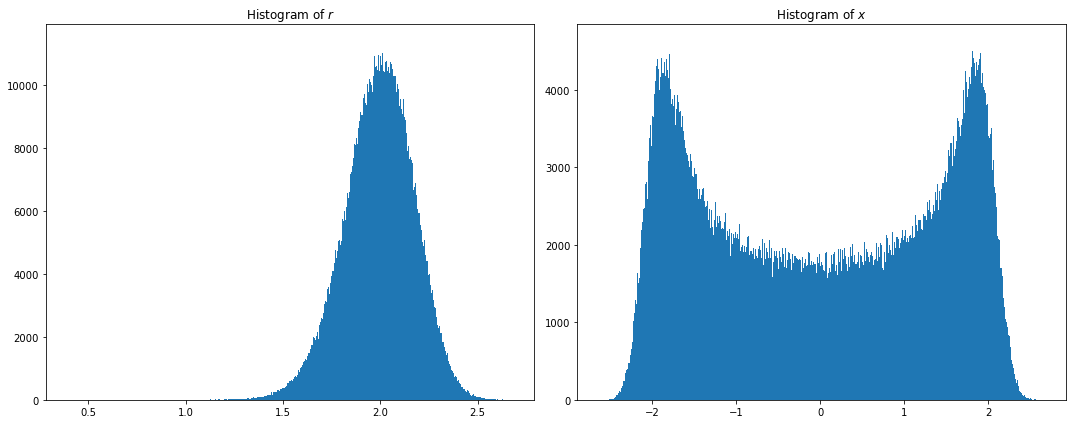

In [10]:
fig, ax = plt.subplots(1, 2, figsize = (15,6))

ax[0].hist(r_observations_l, bins=500)
ax[0].set_title("Histogram of $r$")

ax[1].hist(x_observations_l, bins=500)
ax[1].set_title("Histogram of $x$")

fig.tight_layout()

print("Average of r: {:.4}".format(np.mean(r_observations_l)))
print("Average of x: {:.4}".format(np.mean(x_observations_l)))


* **Question 2**: Implement the bunching method on the data of the two observables and show the corresponding plots. Provide an estimate of the correlation time by comparing the naive standard
deviation of the data with the standard deviation obtained by the bunching method.


#### Answer space  (two figures are expected)

$$ \tau_x \approx 2^{13} $$

$$ \tau_r \approx 2^{10} $$

Is the correlation time different for the two observables? 

They are different, but I have no idea why.

----------------------------------------------------------------------------------------------

In [5]:
r_observations = np.array(r_observations_l)
x_observations = np.array(x_observations_l)

# Naive error
r_naive_error = np.std(r_observations) / np.sqrt(r_observations.shape[0])
x_naive_error = np.std(x_observations) / np.sqrt(x_observations.shape[0])
print("Naive error estimate of r: {:.3}".format(r_naive_error))
print("Naive error estimate of x: {:.3}".format(x_naive_error))

Naive error estimate of r: 0.000174
Naive error estimate of x: 0.00138


In [6]:
# Bunching
r_bunching_error = np.zeros(20)
x_bunching_error = np.zeros(20)
for bunching_level in range(20):
    r_bunching_error[bunching_level] = np.std(r_observations) / np.sqrt(r_observations.shape[0])
    x_bunching_error[bunching_level] = np.std(x_observations) / np.sqrt(x_observations.shape[0])
    r_observations = np.average(r_observations.reshape(-1, 2), axis=1)
    x_observations = np.average(x_observations.reshape(-1, 2), axis=1)

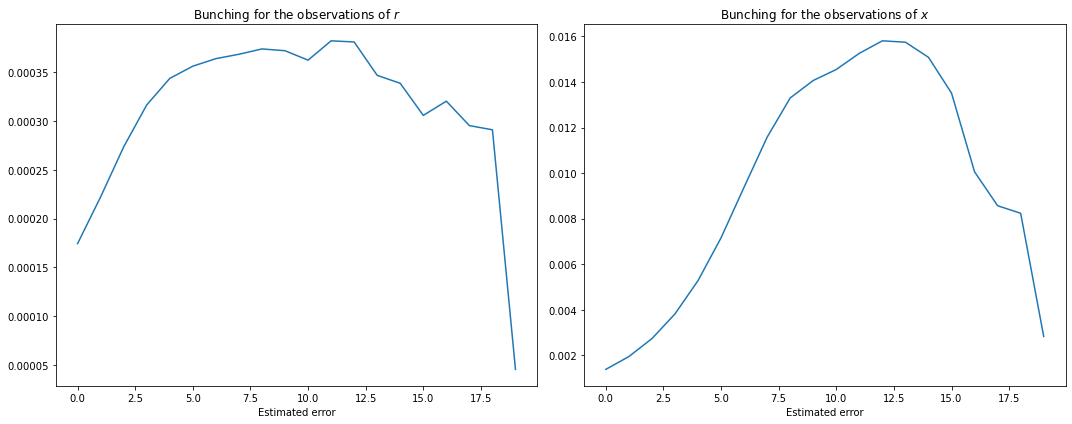

In [7]:
fig, ax = plt.subplots(1, 2, figsize = (15,6))

ax[0].plot(r_bunching_error)
ax[0].set_title("Bunching for the observations of $r$")
ax[0].set_xlabel("Bunching level")
ax[0].set_xlabel("Estimated error")

ax[1].plot(x_bunching_error)
ax[1].set_title("Bunching for the observations of $x$")
ax[1].set_xlabel("Bunching level")
ax[1].set_xlabel("Estimated error")

fig.tight_layout()

print()


* **Question 3**: Provide the estimation of both observables with their statistical erorrs:


#### Answer space 

$$ \langle x\rangle =  0.003 \pm  1.5 \times 10^{-2} $$

$$\langle r\rangle = 1.992 \pm  3 \times 10^{-4} $$ 

----------------------------------------------------------------------------------------------

The output of the previous program is a long list of correlated data: $x_0,x_1,\dots,x_i,\ldots$ and $r_0,r_1,\dots,r_i,\ldots$ \\
For both observables one can study statistical correlations via the following autocorrelation functions 

$$C_r(n)= \langle (r_i-\langle r\rangle)(r_{i+n}-\langle r\rangle)\rangle $$

$$ C_x(n)= \langle (x_i-\langle x\rangle)(x_{i+n}-\langle x\rangle)\rangle $$

Here we consider a single long Markov chain so that both $C_r(n)$ and $C_x(n)$ are independent of $i$, so that the stationary limit is reached.

* **Question 4**: Estimate numerically both $C_r(n)$ and $C_x(n)$ for $n=0,1,\ldots, n_{\text{range}}$. \\
In order to observe the decay of the correlations to zero, we need to employ a sufficiently large value for $n_\text{range}$. If $n_\text{range}$ is smaller   than the correlation time of the observables, the decay to zero cannot be observed. On the other hand, assigning $n_{\text{range}}\approx N_{\text trials}$ would result in strong fluctuations due to the lack of statistics. Try to find a good value of $n_{\text{range}}$ for each observable.

#### Answer space
A program for the data analysis with two nice linear plots. Correct values of $n_{\text{range}}$ are expected.

----------------------------------------------------------------------------------------------

In [15]:
r_observations = np.array(r_observations_l)
x_observations = np.array(x_observations_l)

r_cor = [np.var(r_observations)]
for k in range(1, 15):
    r_cor.append(np.cov(r_observations[:-k], r_observations[k:])[0,1])

x_cor = [np.var(x_observations)]
for k in tqdm(range(1, 350)):
    x_cor.append(np.cov(x_observations[:-k], x_observations[k:])[0,1])

  0%|          | 0/349 [00:00<?, ?it/s]

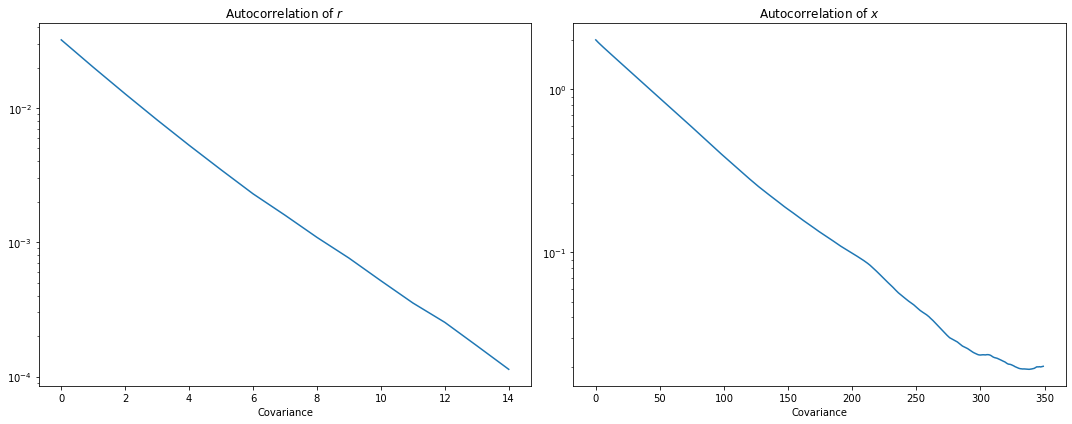

In [16]:
fig, ax = plt.subplots(1, 2, figsize = (15,6))

ax[0].plot(r_cor)
ax[0].set_title("Autocorrelation of $r$")
ax[0].set_xlabel("n_range")
ax[0].set_xlabel("Covariance")
ax[0].set_yscale("log")

ax[1].plot(x_cor)
ax[1].set_title("Autocorrelation of $x$")
ax[1].set_xlabel("n_range")
ax[1].set_xlabel("Covariance")
ax[1].set_yscale("log")

fig.tight_layout()

print()

 
* **Question 5**: Check numerically if the errors obtained using the following formula 

$$ \text{error} = \sqrt{\frac{C(0) + 2 \sum_{n=1}^{n_{\text{range}}} C(n)}{N_{\text{trials}}}} $$

are consistent with the results obtained using the bunching method

#### Answer space 

$$ \langle x\rangle =  0.003 \pm  1.5 \times 10^{-2} $$

$$\langle r\rangle = 1.992 \pm  3.7 \times 10^{-4} $$ 

This result **is** consistent with the error found with the bunching method.

--------------------------------

In [17]:
r_error = np.sqrt((r_cor[0] + 2*np.sum(r_cor[1:])) / 2**20)
x_error = np.sqrt((x_cor[0] + 2*np.sum(x_cor[1:])) / 2**20)
print("Error estimate of r: {:.3}".format(r_error))
print("Error estimate of x: {:.3}".format(x_error))

Error estimate of r: 0.000373
Error estimate of x: 0.0154


## <center>Part II:  Markov chain and Google's PageRank </center>

### **References**

* <a href="http://infolab.stanford.edu/~backrub/google.html">The original PageRank paper by Google’s founders Sergey Brin and Lawrence Page</a>
* A useful lecture is the <a href="http://infolab.stanford.edu/~ullman/mmds/ch5.pdf">Chap. 5 of Mining of Massive Datasets by J. Leskovec, A. Rajaraman, J. Ullman</a>

In the first lecture, we introduced the MCMC (Markov Chain Monte Carlo) and its most famous representative : the Metropolis algorithm. We also discussed the properties of the transition (or Markov) matrix and the convergence of the MCMC. Here we will see a second and very important application of the transition matrix: the PageRank.

### **History**

The World Wide Web was born in the nineties and grew up very fast. There were 623 web sites in 1993, more than one million in 1997, and today we can count more than a billion of web sites. How do you find your desired web page in such a jungle?

At the end of the nineties the most popular search engines, like AltaVista or Yahoo!, were focused on the relevance of some keywords: a short list of results was obtained by estimating the number of occurrence and the location (title, abstract, main text...) of the keywords in the document. Unfortunately spam sites were able to find their way to get in that list by repeating many keywords. In 1997, the top search results of the keyword 'Titanic' contained a small fraction of sites dedicated to the actual sad story of the British passenger liner or the movie with Leo Di Caprio and Kate Winslet.

To fight against spam, two students of Standford, Brin and Page, proposed as a solution to this problem PageRank, an algorithm that establishes the importance of a web site using transition matrix theory. Thanks to this idea, Brin and Page founded in 1998 a new company: Google.

### **The Idea**

The World Wide Web has the topological structure of an oriented graph: a site can link to (and be linked by) other sites. 

In their original paper Brin and Page imagine a Random Surfer that at each time-step moves from a visited page to a new one by selecting at random one of the possible links. The PageRank of the WWW is given by the occupation probabilities of the sites in the stationary state.

### **The PageRank algorithm**

Consider a site $a$ that links to list of sites, that we call neighbor$[a]=[a_1,a_2,\ldots]$. For an oriented graph the fact that $a_1$ is in the list of neighbor$[a]$ does not imply that  $a$ is in the list of neighbor$[a_1]$. We define 
* the **out-degree**, $K_a^{\text{out}}$, the number of outgoing links from $a$:
$$ K_a^{\text{out}} = \text{len}(\text{neighbor}[a])$$
* the **in-degree**  , $K_a^{\text{in}}$, the number of links that points the site $a$.


The Markov matrix $T$ for a random  surfer is such that the matrix  element
$T_{ba}$, corresponding to the move from $a\to b$, is:
$$ T_{ba} =
\begin{cases}
1/K_a^{\text{out}} &\text{if} \;  b \in \text{neighbor}[a] \\
\\
0  & \text{otherwise}
\end{cases}
$$
We first define the PageRank of the graph as the stationary state, $\pi = T \pi$. In particular the PageRank (namely the score) associated to a site $a$ is
$\text{PR}(a)= \pi_a$.   Starting from the general global balance equation
$$  \sum_{b\ne a} \pi_a p_{a \to b} = \sum_{b\ne a} \pi_b p_{b \to a} =  \sum_{b} \pi_a T_{ba} = \sum_{b} \pi_b T_{ab}$$
You can show the validity of the PageRank equation written by Page and Brin
$$ \text{PR}(a) = \sum_{a \in \text{neighbor}[b]} \frac{\text{PR}(b)}{K_b^{\text{out}}} $$

### The 3x3 pebble game with PageRank

To provide a concrete example consider again the traditional $3\times 3$ pebble game but implement the PageRank algorithm instead of the Metropolis algorithm.

**Question 6**
* Find the stationary state of this specific Markov chain. Are the position still evenly sampled?
* By studying the spectrum of the Markov matrix, determine the properties of the Markov chain (periodic or aperiodic, reducible or irreducible).

**Code remainder** \\
We recall that in Python/Numpy it is possible to create a matrix easily. Say that we have a Markov chain with two states, $a$ and $b$, with the following transition probabilities:
$$p_{a \to a} = 0.3 \quad p_{a \to b} = 0.7$$
$$p_{b \to a} = 0.5 \quad p_{a \to b} = 0.5$$
The transition matrix $P$ will be constructed as follows:

```
P = np.array([[0.3, 0.5],[0.7, 0.5]])
```

Numpy (accessed through np.) constructs explicity matrices by passing a list of the rows. Of course this can help when the matrix is not too big, otherwise different methods must be adopted. If one wants to pass the columns can use the transpose operation .T (notice it at the end of np.array(...))

```
P = np.array([[0.3, 0.7],[0.5, 0.5]]).T
```

In [18]:
import networkx as nx

P = nx.to_numpy_matrix(nx.grid_graph((3,3)))
P = (P / np.sum(P, axis=1)).T   # Make the matrix stochastic
eigvals, eigvecs = np.linalg.eig(P)
stationnary_distribution = eigvecs[:,np.argsort(eigvals)[-1]]
stationnary_distribution /= np.sum(stationnary_distribution)
print("Stationnary distribution:")
print(stationnary_distribution)

Stationnary distribution:
[[0.08333333]
 [0.125     ]
 [0.08333333]
 [0.125     ]
 [0.16666667]
 [0.125     ]
 [0.08333333]
 [0.125     ]
 [0.08333333]]


In [19]:
eigvals

array([ 1.00000000e+00, -1.00000000e+00,  5.77350269e-01,  1.08694845e-16,
       -5.77350269e-01, -5.77350269e-01,  6.43256026e-17,  5.77350269e-01,
        0.00000000e+00])

**Answer space**

* The stationary state for PageRank is (a program is expected)

\begin{align}
\pi(1)&=1/12 \\ \pi(2)&=1/8 \\ \pi(3)&=1/12 \\ \pi(4)&=1/8 \\ \pi(5)&=1/6 \\ \pi(6)&=1/8 \\ \pi(7)&=1/12 \\ \pi(8)&=1/8 \\ \pi(9)&= 1/12
\end{align}

* The PageRank version of the $3\times 3$  is a **periodic and irreducible** Markov Chain ($-1$ is also an eigenvalue).

--------------------------------------------

### Dead Ends and Spider Traps

The PageRank described above works if the Markov matrix is irreducible, 
but several snares are hidden in the WWW: the Surfer can find a **dead end**, 
    namely a web page that does not contain links, or, even worst, can jump 
    in a **spider trap**, e.g. a set of nodes with no dead ends but no links with the outside world. 

The strategy to deal with them is called taxation. It relies on a damping parameter $d$ that we take in the interval $[0,1]$ (here take $d=0.85$) The novel dynamics can be written as
$$ \vec{\pi}(t+1) = d\, T\vec{\pi}(t) + \frac{1−d}{n}\vec{J}\quad \text{ where }\vec{J} = \begin{pmatrix} 1\\ \vdots \\1\end{pmatrix} $$
here $n$ is the total number of web pages (the total number of nodes).
One can show that in presence of taxation the PageRank formula writes
$$ \text{PR}(a) = d\sum_{b \text{ connected to } a} \frac{\text{PR}(b)}{K_b^{\text{out}}} + \frac{1−d}{n}  $$
Taxation modifies the dynamics of Random Surfers and solves the problem of both spider traps and dead ends (to ensure probability conservation, in the case of a dead end, the Markov Matrix $T$ has a $1$ on the diagonal for the corresponding node).

**Question 7:** Provide the PageRank with this prescription and 𝑑=0.85 for the neighbour below.  Identify the dead end or the spider trap.




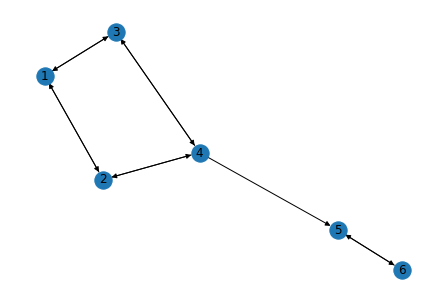

In [22]:
neighbor_list = {1 : [2, 3], 2 : [1, 4], 3 : [1, 4], 4 : [2, 3, 5], 5 : [6], 6 : [5]}

g = nx.DiGraph(neighbor_list)
nx.draw(g, with_labels=True)

If we define $M$ as the $n \times n$ matrix filled with $1$ then $J = M \pi(t)$ for any probability distribution $\pi(t)$, allowing us to rexpress the equation of the markov chain with taxation as a normal markov chain equation with a term:
$$ \frac{1 - d}{n} M $$

In [27]:
d = 0.85
n = g.number_of_nodes()

P = nx.to_numpy_matrix(g)
P = (P / np.sum(P, axis=1)).T   # Make the matrix stochastic
P = d * P + ((1 - d) / n) * np.full((n,n), 1)

eigvals, eigvecs = np.linalg.eig(P)
stationnary_distribution = eigvecs[:,np.argsort(eigvals)[-1]]
stationnary_distribution /= np.sum(stationnary_distribution)
print("Stationnary distribution:")
print(stationnary_distribution)

Stationnary distribution:
[[0.11623037]
 [0.10732984]
 [0.10732984]
 [0.11623037]
 [0.28534031]
 [0.26753927]]


**Answer space**

A program is expected to answer this question. 

The neighbor_list contains a **spider trap in the sites 5 and 6**

The final PageRank for the $6$ web pages is:

$$ \pi(1)=0.116, \quad  \pi(2)= 0.107, \quad \pi(3)= 0.107$$
$$ \pi(4)=0.116, \quad  \pi(5)= 0.285, \quad \pi(6)= 0.267$$

--------------------------

### PageRank performance:

The PageRank algorithm is a time-consuming process to provide a score for each site in the networks. A much simpler and intuitive measure is given by the **in-degree**  , $K_a^{\text{in}}$. In this case, sites with high in-degree are more important. One might think that two measures are equivalent, but this is not the case, especially for complex graphs. To illustrate the difference let's study the citation network **of the first 49 volumes of Physical Review Letters.**

 \\
The dataset you find here lets you reconstruct the adjacency matrix  of the citation network:
$$A_{ij} = 
\begin{cases}
1 & \text{if the paper} \; j \; \text{cites the paper} \; i \\
0 & \text{otherwise}
\end{cases}
$$

Please follow the instruction below to download the dataset.

We don't leave the creation of the adjacency matrix and the transition matrix to you. Just execute the code box below and the adjacency matrix will be saved in a variable named $A$

In [28]:
#don't change this code, it is necessary for the creation of the adjacency matrix
import pandas as pd
import networkx as nx
import numpy as np
import warnings
import scipy as sc
import scipy.sparse as sparse
import matplotlib.pyplot as plt
adj_list = pd.read_csv('adj_list.txt', sep=' ', header=None)
adj_list.columns = ['from','to']
g = nx.from_pandas_edgelist(adj_list, source='from', target='to', create_using=nx.DiGraph())
A = nx.linalg.graphmatrix.adjacency_matrix(g, dtype=int).toarray().T
dead_ends = np.where(A.sum(axis=0)==0)[0]
A[(dead_ends, dead_ends)] = 1
#A_sparse = sp.sparse.csr_matrix(A, dtype=float)
n_nodes = A.shape[0]
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    temp = np.sum(A, axis=0)
    T = A/temp
    T[~np.isfinite(T)] = 0
#T_sparse = sp.sparse.csr_matrix(T, dtype=float)
# the variable A contains the adjacency matrix of the network
# the variable n_nodes contains the number of nodes of the network

C:\Users\Adrie\AppData\Local\Temp\ipykernel_5072\3166974859.py:12: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.linalg.graphmatrix.adjacency_matrix(g, dtype=int).toarray().T


**Question 8**
* Compute the in-degree of each paper, namely the number of citations of each paper (a program is expected).

* Using the in-degree as a measure, rank the first 10 papers of the network: the first paper in the ranking is the one with the highest in-degree, the second the one with the second highest in-degree...

**Question 9**
* Compute the PageRank $PR(a)$ associated to each paper (a program is expected; use $d=0.85$).

* Using the $PR(a)$ as a measure, rank the first 10 papers of the network: the first paper in the ranking is the one with the highest PageRank, the second the one with the second highest PageRank...
* Compare the two rankings and see if there are differences.

<!-- N.B.: since in the network some dead-ends are present, $T$ is not a proper Markov Matrix: some $j^*$ exists such that $\sum_i T_{ij^*}=0$. The fact that we are using $d \neq 1$ ensures that the PageRank exists however it is not anymore a probability i.e. $\sum_a \pi_a$ will be different from $1$. -->

**Question 10** \\
* Compute the in-degree and the out-degree of the network and make an histogram for each.
* Compute the in-degree for the highest ranked nodes according to both the in-degree and the PageRank rankings. Do you notice any difference?

**Answer Space**


--------------------------

In [29]:
# We subtract the diagonal to avoid counting the loops on dead ends

in_degrees = np.sum(A, axis=1) - A.diagonal()
out_degrees = np.sum(A, axis=0) - A.diagonal()
indegree_top = np.flip(np.argsort(in_degrees)[-10:])
print("10 first papers in terms of in-degree:")
print(indegree_top)

10 first papers in terms of in-degree:
[1367 3900 3903  375 2079 1031 1533 3902 4955 1063]


In [30]:
d = 0.85

P = (A / np.sum(A, axis=0))
P = d * P + ((1 - d) / n_nodes) * np.full((n_nodes,n_nodes), 1)

eigvals, eigvecs = np.linalg.eig(P)
stationnary_distribution = eigvecs[:,np.argsort(eigvals)[-1]]
stationnary_distribution /= np.sum(stationnary_distribution)
pagerank_top = np.flip(np.argsort(stationnary_distribution)[-10:])
print("10 first papers in terms of in-degree:")
print(pagerank_top)

10 first papers in terms of in-degree:
[ 466   26  665  280  465  574  310 1966 3903  761]


The rankings are pretty different, there is only one paper appearing in both top 10.

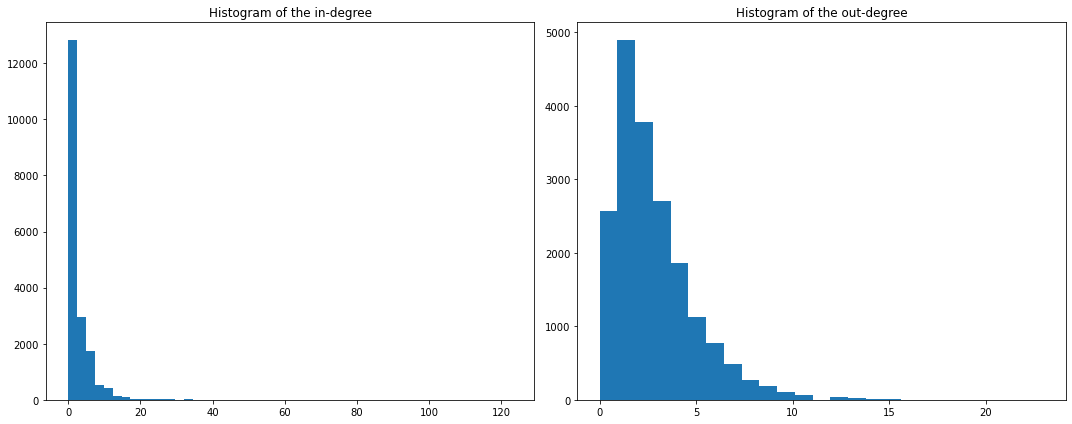

In [31]:
fig, ax = plt.subplots(1, 2, figsize = (15,6))

ax[0].hist(in_degrees, bins = 50)
ax[0].set_title("Histogram of the in-degree")

ax[1].hist(out_degrees, bins = 25)
ax[1].set_title("Histogram of the out-degree")

fig.tight_layout()

print()

The histograms make sense: papers all cite roughly the same amount of papers, but some papers are very cited while others very little.

In [32]:
print("In-degree of the top papers according to in-degree:")
print(in_degrees[indegree_top])
print("\nIn-degree of the top papers according to pagerank:")
print(in_degrees[pagerank_top])

In-degree of the top papers according to in-degree:
[123 104  96  91  70  64  63  63  57  56]

In-degree of the top papers according to pagerank:
[28 43 15  9  9 15  9 32 96 27]


As expected, the top papers according to PageRank don't have the top in-degrees, but still have much higher in-degrees than the average paper.